In [1]:
import hdbscan
import pandas as pd

fname = 'problems_nodup.2d.csv'
df = pd.read_csv(fname)
# filt = pd.read_csv('problems_nomatch.csv')['problem']
# df = df[df['text'].isin(filt)]
df

,text,x,y
0,ENGINE IDLE OVERRIDE KILLED ENGINE.,13.453582,7.025188
1,HAD ENGINE CHOKE & BRIEFLY LOSE POWER ON DEPAR...,12.892288,6.756704
2,#2 & 4 CYL ROCKER COVER GASKETS ARE LEAKING.,-3.353205,6.733334
3,ROCKER BOX COVER SCREWS LOOSE (ALL CYL).,3.294670,12.333794
4,INDUCTION TUBE HOSE CLAMPS LOOSE (ALL CYL).,8.200951,7.786985
...,...,...,...
3590,SCREW MISSING FROM #3 AFT BAFFLE.,8.589211,13.456522
3591,CRACK ON #4 CYLINDER AFT BAFFLE.,7.801578,10.789055
3592,CHT FLUCTUATING,10.348101,5.784105
3593,"DURING RUN UP, #2 CYL WAS COLD & ENGINE SHOCK ...",11.072491,5.420405


unlabeled 218


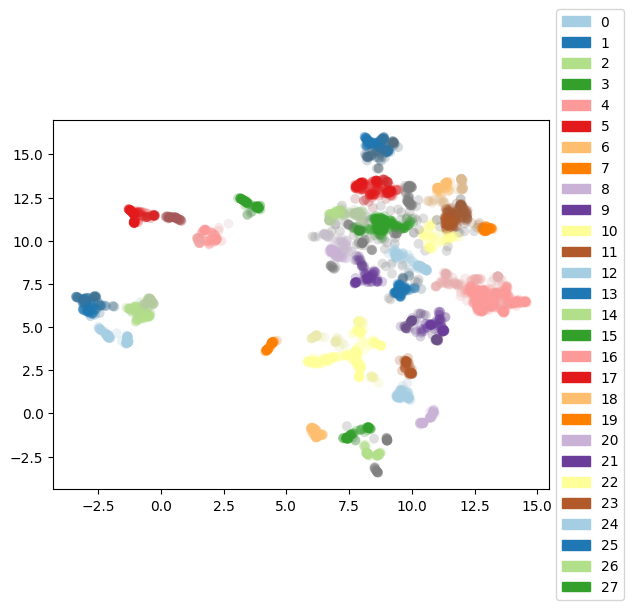

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

data = df[['x','y']].values
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=3, prediction_data=True).fit(data)
n = len(set(clusterer.labels_))
print('unlabeled', sum(clusterer.labels_ == -1))
color_palette = sns.color_palette('Paired', n)

cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.legend([mpatches.Patch(color=b) for b in color_palette][:-1], 
           list(set(clusterer.labels_))[:-1],
           loc='center left', bbox_to_anchor=(1, 0.5))

In [3]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from IPython.display import HTML

vec = TfidfVectorizer(stop_words='english', min_df=10, max_df=.1, ngram_range=(1,4))
wc = vec.fit_transform(df['text'])
display(wc)
vocab = vec.get_feature_names_out()
for l in set(clusterer.labels_):
    words = np.asarray(wc[clusterer.labels_ == l].mean(axis=0))
    top = pd.Series(words[0], index=vocab)
    top = (top * (top.index.str.count(' ')+1)).sort_values(ascending=False).head(50)
    top = top[top.index.map(lambda v: sum(top.head(10).index.str.contains(v))) <= 1]
    display(HTML(f'<tt style="color:{color_palette.as_hex()[l]}">{l:02d} {list(top.head().index)}</tt>'))

<3595x472 sparse matrix of type '<class 'numpy.float64'>'
	with 17684 stored elements in Compressed Sparse Row format>

<Axes: ylabel='$\\lambda$ value'>

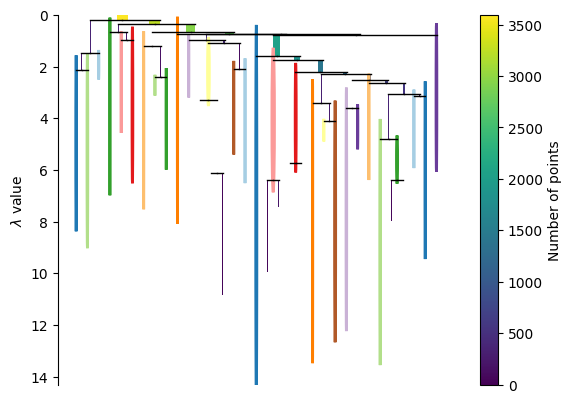

In [4]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=color_palette)

In [5]:
tree = clusterer.condensed_tree_.to_pandas()
children = {}
for p,c in tree[['parent','child']].values:
    children.setdefault(p, set()).add(c)

cluster_tree = tree[tree.child_size > 1]
cluster_children = {}
for p,c in cluster_tree[['parent','child']].values:
    cluster_children.setdefault(p, set()).add(c)

def get_all_children(p):
    for c in children.get(p, []):
        yield c
        yield from get_all_children(c)

labeled = tree.merge(pd.Series(clusterer.labels_, name='label'), left_on='child', right_index=True)
parent_label = dict(labeled.groupby('parent').apply(lambda df: df['label'].iloc[0]))

vec = TfidfVectorizer(stop_words='english', min_df=10, max_df=.1, ngram_range=(1,4))
wc = vec.fit_transform(df['text'])
display(wc)
vocab = vec.get_feature_names_out()
subcluster_words = {}
for l in cluster_tree['child']:
    words = np.asarray(wc[[i for i in get_all_children(l) if i < wc.shape[0]]].mean(axis=0))
    top = pd.Series(words[0], index=vocab)
    top = (top * (top.index.str.count(' ')+1)).sort_values(ascending=False).head(50)
    top = top[top.index.map(lambda v: sum(top.head(10).index.str.contains(v))) <= 1]
    subcluster_words[l] = list(top.head().index)

def print_level(p, n):
    for c in cluster_children.get(p, []):
        desc = ()
        if parent_label.get(c, -1) > 0:
            desc = '%4d'%len(set(get_all_children(c))), subcluster_words.get(c, [])[:3]
        print('%-35s'%('| '*n + f"{c} {parent_label.get(c, '')}"), *desc)
        print_level(c, n+1)

print_level(wc.shape[0], 0)

<3595x472 sparse matrix of type '<class 'numpy.float64'>'
	with 17684 stored elements in Compressed Sparse Row format>

3596                               
| 3598                             
| | 3602 1                           128 ['rocker cover gaskets leaking', 'rocker gaskets leaking', 'rocker cover gasket leaking']
| | 3603 2                           134 ['rocker cover gaskets leaking', 'rocker cover gasket leaking', 'rocker gaskets leaking']
| 3599 0                           
3597                               
| 3600                             
| | 3604 3                            80 ['rocker cover screws loose', 'box cover screws loose', 'rocker box cover screws']
| | 3605                           
| | | 3608 4                          80 ['rocker covers leaking engine', 'rocker cover leaking engine', 'engine rocker covers leaking']
| | | 3609 5                         141 ['cyl rocker covers leaking', 'cyl rocker cover leaking', 'eng rocker']
| 3601                             
| | 3606                           
| | | 3610 6                          59 ['cyl intake gasket leaking', 'cyl 